### Analyse the accuracies

In [3]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import display, Markdown

<h3> Dictionary for each dataset to its txt file path 

In [4]:
experiment_to_results_path = {
    "bitcoinOTC"    : r'stats/fl_lp/bitcoinOTC_1.txt',
    "UCI"           : r'stats/fl_lp/UCI_1.txt',
    "UCI_no_sharing": r'stats/fl_lp/No_Sharing.txt',
    "UCI_unbalanced": r'stats/fl_lp/Unbalanced.txt',
    "DBLP3"       : r'stats/fl_nc/DBLP3.txt',
    "DBLP3_2"       : r'stats/fl_nc/DBLP3_2.txt',
    "Metis_DBLP3"   : r'stats/fl_nc/Metis_DBLP3.txt',
    "Metis_DBLP5"   : r'stats/fl_nc/Metis_DBLP5.txt',
    "Reddit"        : r'stats/fl_nc/Reddit_1.txt',
    "FedGCN"        : r'stats/fl_lp/FedGCN.txt',
    "DBLP5"       : r'stats/fl_nc/DBLP5_1.txt',
    "DBLP5_Unbalanced": r'stats/fl_nc/Unbalanced.txt',
    "UCI_Metis"     : r'stats/fl_lp/Metis_UCI.txt',
    "Reddit_MinCutFirst": r'stats/gpa/20250716/Reddit_Full/mincut_primary.txt',
    "Reddit_BalanceFirst": r'stats/gpa/20250716/Reddit_Full/balance_primary.txt',
    "Reddit_LabelFirst": r'stats/gpa/20250716/Reddit_Full/label_primary.txt',
    "Reddit_Thres0": r'stats/gpa/20250718/Reddit_Full/thres_0.txt',
    "Reddit_Thres0.1": r'stats/gpa/20250718/Reddit_Full/thres_(0.1).txt',
    "Reddit_Thres0.2": r'stats/gpa/20250718/Reddit_Full/thres_(0.2).txt',
    "Reddit_Thres0.3": r'stats/gpa/20250718/Reddit_Full/thres_(0.3).txt',
    "Reddit_Thres0.4": r'stats/gpa/20250718/Reddit_Full/thres_(0.4).txt',
    "UCI_MinCutFirst": r'stats/gpa/20250716/UCI_Full/mincut_primary.txt',
    "UCI_BalanceFirst": r'stats/gpa/20250716/UCI_Full/balance_primary.txt',
    "DBLP3_MinCutFirst": r'stats/gpa/20250716/DBLP3_Full/mincut_primary.txt',
    "DBLP3_BalanceFirst": r'stats/gpa/20250716/DBLP3_Full/balance_primary.txt',
    "DBLP3_LabelFirst": r'stats/gpa/20250716/DBLP3_Full/label_primary.txt',
    "DBLP5_MinCutFirst": r'stats/gpa/20250716/DBLP5_Full/mincut_primary.txt',
    "DBLP5_BalanceFirst": r'stats/gpa/20250716/DBLP5_Full/balance_primary.txt',
    "DBLP5_LabelFirst": r'stats/gpa/20250716/DBLP5_Full/label_primary.txt',
    "DBLP5_NE_first": r'stats/fast_gpa/20250722/1508.txt',
    "DBLP3_NE_first": r'stats/fast_gpa/20250722/1521.txt',
    "Reddit_NE_first": r'stats/fast_gpa/20250722/1626.txt',
    "DBLP5_NE_last": r'stats/fast_gpa/20250723/1133.txt',
}
DATASET = "DBLP5_NE_last"

<h3> Function to parse each of the txt files that we ran to extract results

In [5]:
def parse_log_file(file_path):
    snapshot_to_local_accs = defaultdict(list)
    snapshot_to_global_accs = defaultdict(list)
    snapshot_aggregated_test_accs = defaultdict(list)
    snapshot_to_class_distribution = {}
    snapshot_to_best_round_metrics = {}
    snapshot_to_subgraph_num_and_distribution = {}

    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    with open(file_path, 'r') as f:
        snapshot = None
        curr_local_list = []
        aggre_test_accs = []
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append(global_acc)


            if '@Local> accuracy' in line:
                snapshot_match_list = re.search(r"\[(.*?)\]", line)
                if snapshot_match_list is not None:
                    curr_local_list.append([float(i) for i in snapshot_match_list.group(1).split(', ') if float(i) > 0])
            else:
                if curr_local_list != []:
                    snapshot_to_local_accs[snapshot].append(curr_local_list)
                    curr_local_list = []
                    
            if "Test Accuracy is" in line:
                snapshot_test_acc_match = re.search(r"Test Accuracy is (\d+\.\d+)", line)
                if snapshot_test_acc_match is not None:
                    aggre_test_accs.append(float(snapshot_test_acc_match.group(1)))
            else:
                if aggre_test_accs != []:
                    snapshot_aggregated_test_accs[snapshot].append(aggre_test_accs)
                    aggre_test_accs = []

            if "Subgraph" in line:
                subgraph_dict_match = re.search(r"Subgraph\s+(\d+):\s+(\{(?:\s*\d+\s*:\s*\d+\s*,?)+\})", line)
                if subgraph_dict_match is not None:
                    if snapshot not in snapshot_to_class_distribution:
                        snapshot_to_class_distribution[snapshot] = {}
                    snapshot_to_class_distribution[snapshot].update({int(subgraph_dict_match.group(1)):eval(subgraph_dict_match.group(2))})

            if "Best Round" in line:
                best_line_match = re.search(r"defaultdict\(None, ({.*})\)", line)
                if best_line_match is not None:
                    snapshot_to_best_round_metrics[snapshot] = eval(best_line_match[1])

            if "Client" in line and "training" in line:
                client_edges_line_match = re.search(r"Client (\d+) has (\d+) positive training edges", line)
                if client_edges_line_match is not None:
                    if snapshot not in snapshot_to_subgraph_num_and_distribution:
                        snapshot_to_subgraph_num_and_distribution[snapshot] = {}
                    snapshot_to_subgraph_num_and_distribution[snapshot].update({int(client_edges_line_match.group(1)):int(client_edges_line_match.group(2))})

            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_local_accs, snapshot_to_global_accs, \
        snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
        snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
        snapshot_to_cut_edges, snapshot_to_edges

snapshot_to_local_accs, snapshot_to_global_accs, \
snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
snapshot_to_cut_edges, snapshot_to_edges\
    = parse_log_file(experiment_to_results_path[DATASET])

## Record Time of Partitioning and Node Embedding Exchange

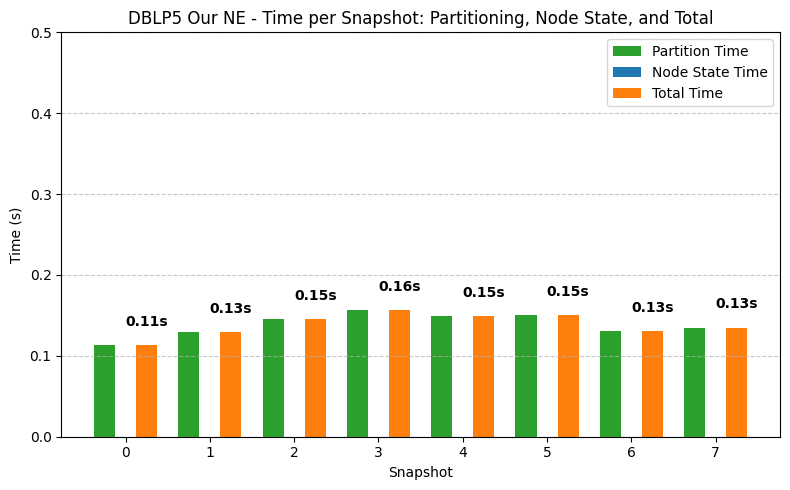

In [6]:
def parse_snapshot_times(filepath):
    snapshot_times = {}

    with open(filepath, 'r') as f:
        lines = f.readlines()

    current_snapshot = None
    for line in lines:
        line = line.strip()

        # Detect snapshot index
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            snapshot_times[current_snapshot] = {
                "partition_time": 0.0,
                "node_state_time": 0.0
            }

        # Partition time
        if "Time taken to partition graph" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["partition_time"] = float(time_match.group(1))

        # Node state computation time
        if "Time taken for Global Node State Computation" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["node_state_time"] = float(time_match.group(1))

    return snapshot_times

def plot_snapshot_times(snapshot_times, dataset=""):
    snapshots = sorted(snapshot_times.keys())
    partition_times = [snapshot_times[s]['partition_time'] for s in snapshots]
    node_state_times = [snapshot_times[s]['node_state_time'] for s in snapshots]
    total_times = [p + n for p, n in zip(partition_times, node_state_times)]

    x = np.arange(len(snapshots))
    width = 0.25

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - width, partition_times, width, label='Partition Time', color='#2ca02c')
    bars2 = plt.bar(x, node_state_times, width, label='Node State Time', color='#1f77b4')
    bars3 = plt.bar(x + width, total_times, width, label='Total Time', color='#ff7f0e')

    # Add total time as text above the bars
    for i, total in enumerate(total_times):
        plt.text(x[i] + width, total + 0.02, f"{total:.2f}s", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Snapshot')
    plt.ylabel('Time (s)')
    plt.ylim((0,0.5))
    plt.title(f'{dataset} - Time per Snapshot: Partitioning, Node State, and Total')
    plt.xticks(x, [f"{s}" for s in snapshots])
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

snapshot_times = parse_snapshot_times(experiment_to_results_path[DATASET])
plot_snapshot_times(snapshot_times, dataset="DBLP5 Our NE")

## Recording Local Client's Accuracies over Snapshots

In [7]:
def parse_snapshot_local_accuracies(filepath):
    """
    Parses local accuracy values from the log file.
    Returns:
        snapshot_to_client_accuracies: dict mapping snapshot -> client_id -> list of accuracies
            {
                0: { 0: [...], 1: [...], ..., n: [...] },
                1: { ... }
            }
    """
    snapshot_to_client_accuracies = defaultdict(lambda: defaultdict(list))
    current_snapshot = None

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()

            # Detect snapshot
            snapshot_match = re.match(r"Snapshot (\d+)", line)
            if snapshot_match:
                current_snapshot = int(snapshot_match.group(1))

            # Detect local accuracies
            if "@Local> accuracy" in line and current_snapshot is not None:
                match = re.search(r"accuracy\s*=\s*\[([^\]]+)\]", line)
                if match:
                    str_values = match.group(1).split(',')
                    float_values = [float(x.strip()) for x in str_values]
                    for client_id, acc in enumerate(float_values):
                        snapshot_to_client_accuracies[current_snapshot][client_id].append(acc)

    return snapshot_to_client_accuracies

def plot_snapshot_client_accuracies(snapshot_to_client_accuracies):
    num_snapshots = len(snapshot_to_client_accuracies)
    num_cols = 2
    num_rows = (num_snapshots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), squeeze=False)
    fig.suptitle("Client Accuracy per Epoch (Grouped by Snapshot)", fontsize=16, y=0.99)

    all_handles = []
    all_labels = []
    collected_labels = set()

    for idx, (snapshot, client_to_accs) in enumerate(sorted(snapshot_to_client_accuracies.items())):
        ax = axes[idx // num_cols][idx % num_cols]

        for client_id, acc_list in sorted(client_to_accs.items()):
            line, = ax.plot(acc_list, label=f'Client {client_id}', linewidth=1)
            
            # Collect handles only once per client (avoiding duplicates)
            if f'Client {client_id}' not in collected_labels:
                all_handles.append(line)
                all_labels.append(f'Client {client_id}')
                collected_labels.add(f'Client {client_id}')

        ax.set_title(f"Snapshot {snapshot}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Adjust layout and add global legend outside plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(0.92, 0.5), title="Clients")

    plt.show()

def plot_combined_accuracy_and_edges(snapshot_to_client_accuracies, snapshot_to_subgraph_num_and_distribution):
    snapshots = sorted(snapshot_to_client_accuracies.keys())
    num_snapshots = len(snapshots)
    
    # Assume 10 clients (0-9); get consistent color mapping using a colormap
    client_ids = list(range(10))
    cmap = plt.colormaps.get_cmap('tab10')  # use tab10 for categorical color palette
    client_colors = {client: cmap(client) for client in client_ids}
    
    fig, axes = plt.subplots(num_snapshots, 2, figsize=(14, 4 * num_snapshots))
    fig.suptitle("Client Accuracy and Edge Count per Snapshot", fontsize=18, y=0.99)

    if num_snapshots == 1:
        axes = np.array([axes])  # ensure 2D array even for one snapshot

    for i, snapshot in enumerate(snapshots):
        # --- Bar chart (left) ---
        edge_ax = axes[i, 0]
        edge_data = snapshot_to_subgraph_num_and_distribution.get(snapshot, {})
        clients = sorted(edge_data.keys())
        edge_counts = [edge_data[client] for client in clients]

        bars = edge_ax.bar(
            clients, edge_counts,
            color=[client_colors[client] for client in clients]
        )
        edge_ax.set_title(f"Snapshot {snapshot}: Edge Distribution")
        edge_ax.set_xlabel("Client ID")
        edge_ax.set_ylabel("#Edges")
        edge_ax.grid(True, axis='y')

        # --- Line plot (right) ---
        acc_ax = axes[i, 1]
        client_to_accs = snapshot_to_client_accuracies[snapshot]
        for client_id, acc_list in sorted(client_to_accs.items()):
            acc_ax.plot(acc_list, label=f"Client {client_id}", linewidth=1.5, color=client_colors[client_id])

        acc_ax.set_title(f"Snapshot {snapshot}: Local Accuracy over Epochs")
        acc_ax.set_xlabel("Epoch")
        acc_ax.set_ylabel("Accuracy")
        acc_ax.set_ylim(0, 1)
        acc_ax.grid(True)

        # --- Per-row legend (only for the line plot) ---
        # handles, labels = acc_ax.get_legend_handles_labels()
        # acc_ax.legend(handles, labels, loc='upper right', fontsize=9)

    # Place one legend outside all line plots (shared)
    handles, labels = axes[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

local_accuracies = parse_snapshot_local_accuracies(experiment_to_results_path[DATASET])

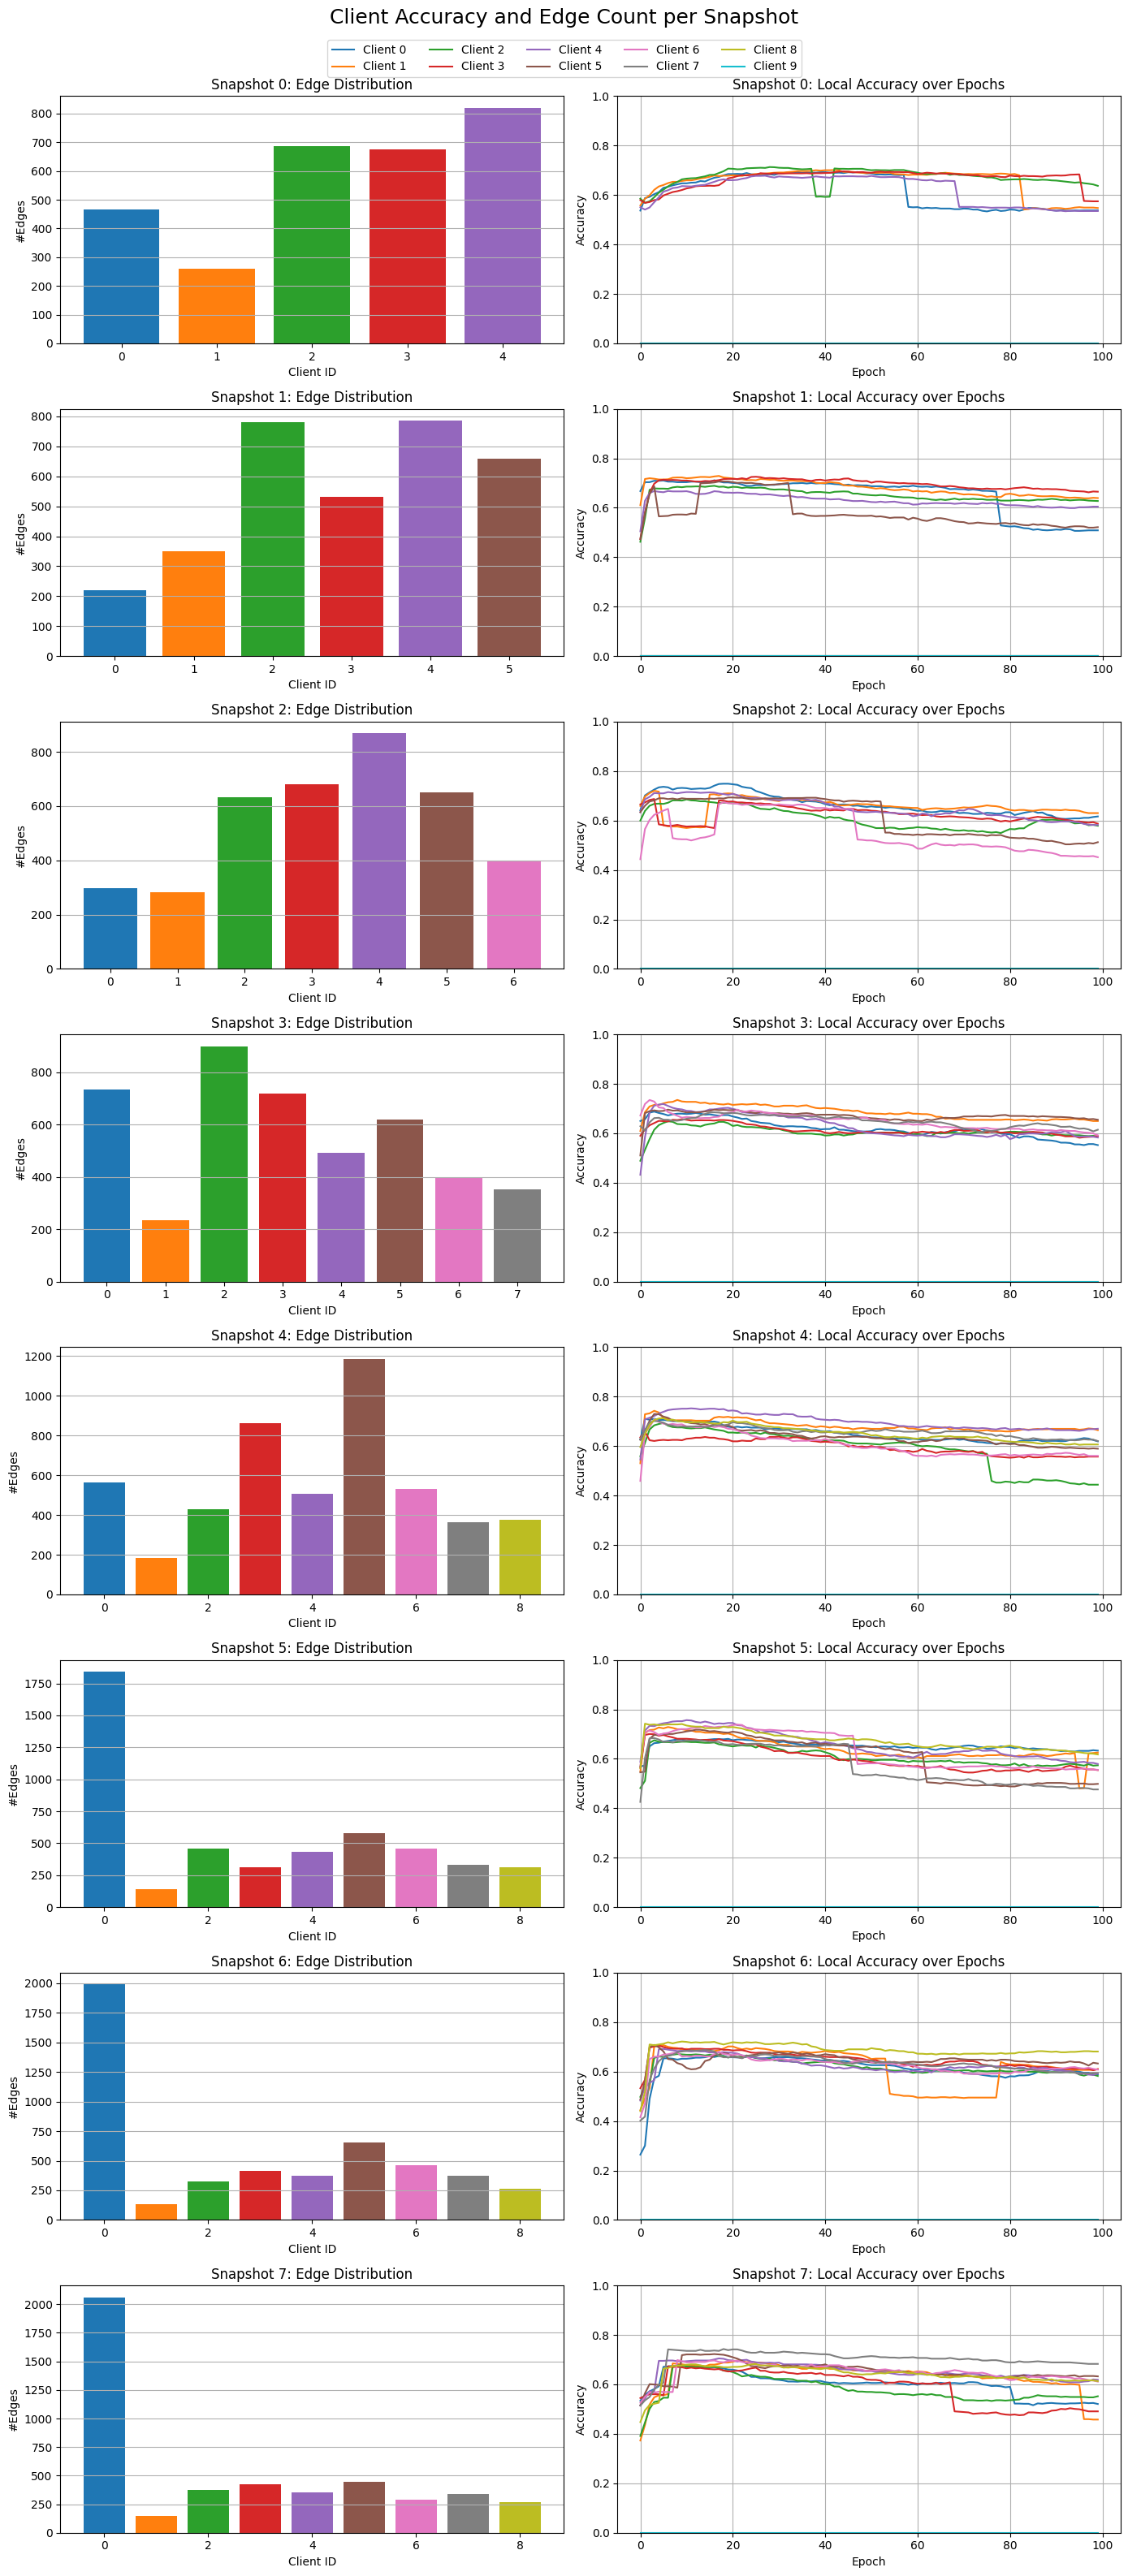

In [8]:
plot_combined_accuracy_and_edges(local_accuracies, snapshot_to_subgraph_num_and_distribution)

<h3> Take a look at the Global Accuracy over Snapshots

In [12]:
def plot_global_accuracy(snapshot_data):
    # Step 1: Flatten all values and track boundaries
    all_values = []
    snapshot_start_indices = []
    index = 0

    for snapshot_id in sorted(snapshot_data.keys()):
        rounds = snapshot_data[snapshot_id][0]
        snapshot_start_indices.append(index)
        for item in rounds:
            all_values.append(item[0])
            index += 1

    # Step 2: Plot the line with snapshot markers
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(all_values)+1), all_values, marker='o', label="Values")

    # Add vertical lines for snapshot boundaries
    for i, snapshot_start in enumerate(snapshot_start_indices):
        if snapshot_start > 0:
            plt.axvline(snapshot_start + 1, color='gray', linestyle='--', alpha=0.6)
            plt.text(snapshot_start + 1.1, max(all_values), f"Snapshot {i}", rotation=90,
                    verticalalignment='bottom', fontsize=10, color='gray')

    # Labels and title
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

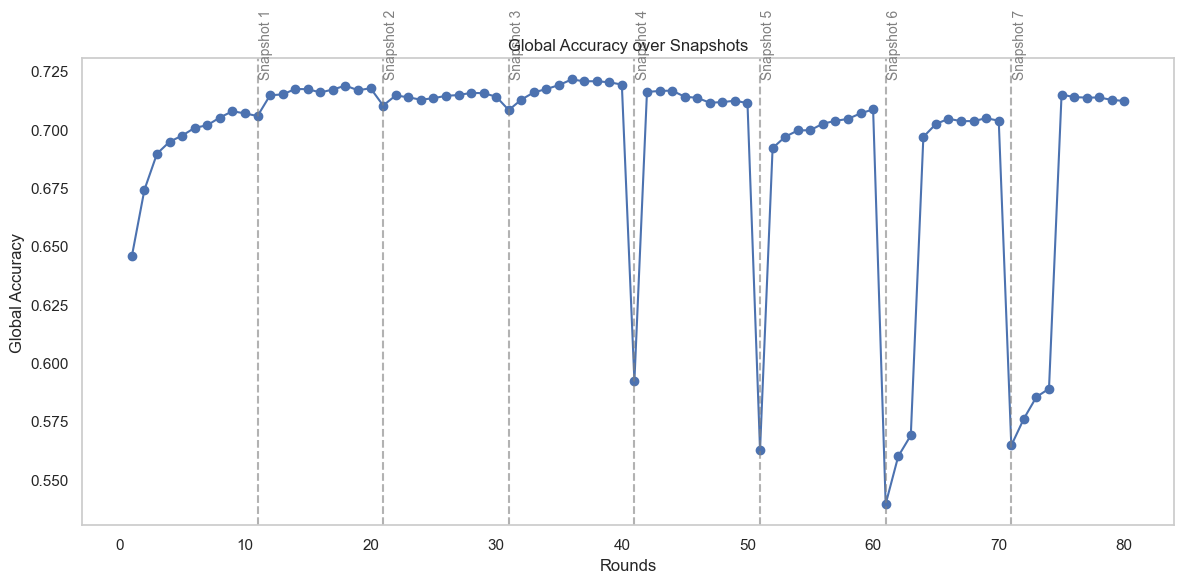

In [22]:
modified_dict = {} # plot_convergence_of_local_accuracies
for snapshot in snapshot_to_global_accs:
    modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
    
plot_global_accuracy(modified_dict)

## Extracting the Node Class Distributions for Node Classification Tasks

In [ ]:
def get_multi_index_table_for_label_distribution(snapshot_to_class_distribution):
    df = pd.DataFrame.from_dict(
        {(outer_k, inner_k): values for outer_k, inner_dict in snapshot_to_class_distribution.items() for inner_k, values in inner_dict.items()},
        orient='index'
    )

    # Set MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Snapshot", "Class Labels"]).T

    # Transpose the DataFrame
    df_transposed = df.T

    # Show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    # df_transposed.to_csv("output.csv")
    return df_transposed

get_multi_index_table_for_label_distribution(snapshot_to_class_distribution)

### Calculate Shannon Entropy for Label Diversity

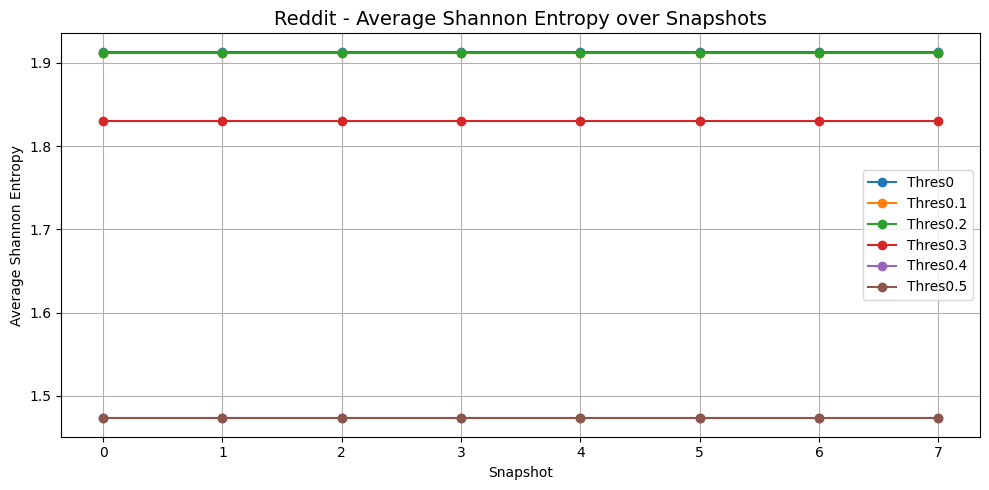

In [32]:
def compute_shannon_entropy(label_counts: dict) -> float:
    total = sum(label_counts.values())
    if total == 0:
        return 0.0
    probs = np.array([count / total for count in label_counts.values()])
    return -np.sum(probs * np.log2(probs + 1e-12))  # small epsilon to prevent log(0)

def compute_snapshot_entropy(snapshot_to_class_distribution):
    snapshot_entropy = {}
    for snapshot, subgraph_label_dict in snapshot_to_class_distribution.items():
        entropies = []
        for subgraph, label_dist in subgraph_label_dict.items():
            entropy = compute_shannon_entropy(label_dist)
            entropies.append(entropy)
        if entropies:
            snapshot_entropy[snapshot] = np.mean(entropies)
        else:
            snapshot_entropy[snapshot] = 0.0
    return snapshot_entropy

def plot_entropy_across_snapshots(strategy_to_entropy_dict, dataset=""):
    plt.figure(figsize=(10, 5))
    for strategy, entropy_dict in strategy_to_entropy_dict.items():
        snapshots = sorted(entropy_dict.keys())
        entropy_values = [entropy_dict[s] for s in snapshots]
        plt.plot(snapshots, entropy_values, label=strategy, marker='o')

    plt.xlabel("Snapshot")
    plt.ylabel("Average Shannon Entropy")
    plt.title(f"{dataset} - Average Shannon Entropy over Snapshots", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

strategy_to_entropy = {}
for strategy, path in zip(["Thres0", "Thres0.1", "Thres0.2","Thres0.3","Thres0.4","Thres0.5"], ["Reddit_Thres0", "Reddit_Thres0.1", "Reddit_Thres0.2", "Reddit_Thres0.3", "Reddit_Thres0.4", "Reddit_MinCutFirst"]):
    _, _, _, snapshot_to_class_distribution, *_ = parse_log_file(experiment_to_results_path[path])
    snapshot_entropy = compute_snapshot_entropy(snapshot_to_class_distribution)
    strategy_to_entropy[strategy] = snapshot_entropy

plot_entropy_across_snapshots(strategy_to_entropy, dataset="Reddit")

## Plot cut edges in each subgraph

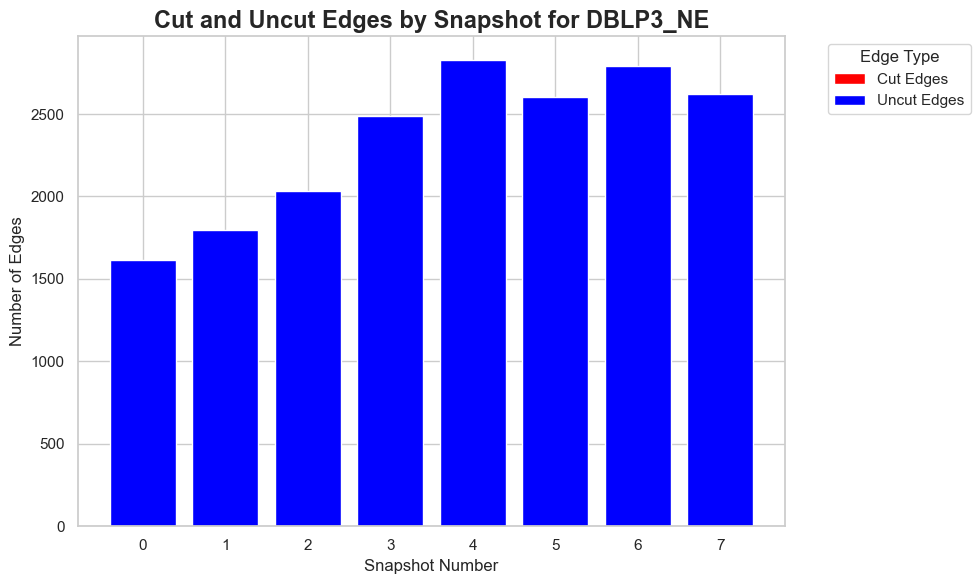

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_edge(data, dataset):
    # Prepare data for plotting
    x = list(data.keys())  # X-axis (keys of the dictionary)
    num_bars = max(len(v) for v in data.values())  # Number of bars (length of the longest list)

    # Collect the values for each bar group
    values = [list(d.values()) for d in data.values()]
    
    # Pad shorter lists with 0s to match the longest one
    padded_values = [v + [0] * (num_bars - len(v)) for v in values]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(padded_values, columns=[f'Client {i}' for i in range(num_bars)])
    df['Snapshot'] = x
    
    # Normalize the values to represent proportions
    df_proportions = df.drop(columns='Snapshot').apply(lambda x: x / x.sum(), axis=1)
    df_proportions['Snapshot'] = df['Snapshot']

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 7))

    # Plot a stacked bar chart
    ax = df_proportions.set_index('Snapshot').plot(kind='bar', stacked=True, figsize=(12, 7),
                                                   colormap='viridis', width=0.8)
    plt.xlim(12,23)
    # Customize plot labels and title
    ax.set_xlabel('Snapshot Number', fontsize=12)
    ax.set_ylabel('Proportion of Edges', fontsize=12)
    ax.set_title(f'Stacked Bar Plot of Edge Distribution by Snapshot for {dataset}', fontsize=20, fontweight="bold")
    
    # Adjust the legend
    plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()

    # Show plot
    plt.show()

def plot_cut_edges(data, dataset):
    # Extract the first and second elements of the tuple (cut and uncut edges)
    first_elements = [first for first, second in data.values()]  # cut edges
    second_elements = [second for first, second in data.values()]  # uncut edges

    # Prepare the x-axis (snapshot numbers)
    snapshots = list(data.keys())

    # Plotting
    sns.set(style="whitegrid")  # Set Seaborn style

    plt.figure(figsize=(10, 6))

    # Create a stacked bar plot
    bar_width = 0.8  # width of the bars
    index = np.arange(len(snapshots))  # X-axis positions

    # Plot the first (red) part of the bars (cut edges)
    plt.bar(index, first_elements, bar_width, color='red', label='Cut Edges')

    # Plot the second (blue) part of the bars (uncut edges) on top of the first
    plt.bar(index, second_elements, bar_width, bottom=first_elements, color='blue', label='Uncut Edges')

    # Customize the plot
    plt.xlabel('Snapshot Number', fontsize=12)
    plt.ylabel('Number of Edges', fontsize=12)
    plt.title(f'Cut and Uncut Edges by Snapshot for {dataset}', fontsize=17, fontweight="bold")

    # Set x-ticks to be the snapshot numbers
    plt.xticks(index, snapshots)

    # Add a legend
    plt.legend(title='Edge Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()
    plt.show()

both = defaultdict(tuple)
snapshot = 0
for cut, total in zip(snapshot_to_cut_edges.values(), snapshot_to_edges.values()):
    both[snapshot] = (cut, total)
    snapshot += 1

plot_cut_edges(both, DATASET)

## Calculate Coefficient of Variation (CoV) for each snapshot

In [15]:
def compute_cov(values):
    if not values or np.mean(values) == 0:
        return 0.0
    return np.std(values) / np.mean(values)

def parse_snapshots(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    snapshot_data = defaultdict(lambda: {'train': [], 'val': [], 'test': []})
    current_snapshot = None

    for line in lines:
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            continue

        client_match = re.match(
            r"Client \d+ has (\d+) positive training edges, (\d+) positive val edges and (\d+) positive test edges", 
            line
        )
        if client_match and current_snapshot is not None:
            train, val, test = map(int, client_match.groups())
            snapshot_data[current_snapshot]['train'].append(train)
            snapshot_data[current_snapshot]['val'].append(val)
            snapshot_data[current_snapshot]['test'].append(test)

    return snapshot_data

def compute_cov_per_snapshot(strategy_to_data):
    snapshot_ids = sorted(next(iter(strategy_to_data.values())).keys())

    train_covs = {strategy: [] for strategy in strategy_to_data}
    val_covs = {strategy: [] for strategy in strategy_to_data}
    test_covs = {strategy: [] for strategy in strategy_to_data}

    for snap_id in snapshot_ids:
        for strategy, data in strategy_to_data.items():
            train_cov = compute_cov(data[snap_id]['train']) * 100
            val_cov = compute_cov(data[snap_id]['val']) * 100
            test_cov = compute_cov(data[snap_id]['test']) * 100

            train_covs[strategy].append(train_cov)
            val_covs[strategy].append(val_cov)
            test_covs[strategy].append(test_cov)

    return snapshot_ids, train_covs, val_covs, test_covs

def plot_cov_comparison(snapshot_ids, train_covs, val_covs, test_covs, dataset=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Automatically assign distinct colors to each strategy
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    strategies = list(train_covs.keys())
    cmap = plt.colormaps.get_cmap('tab10')
    strategy_colors = {strategy: cmap(i) for i, strategy in enumerate(strategies)}

    # Set font sizes
    title_fontsize = 16
    label_fontsize = 14
    tick_fontsize = 12
    legend_fontsize = 12
    suptitle_fontsize = 20

    for ax, covs, title in zip(
        axes,
        [train_covs, val_covs, test_covs],
        ['Training Edge CoV (%)', 'Validation Edge CoV (%)', 'Test Edge CoV (%)']
    ):
        for strategy, values in covs.items():
            ax.plot(snapshot_ids, values, label=strategy, marker='o', color=strategy_colors[strategy])
        ax.set_title(title, fontsize=title_fontsize)
        ax.set_xlabel('Snapshot', fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        ax.grid(True, linestyle='--', alpha=0.5)

    axes[0].set_ylabel('Coefficient of Variation (%)', fontsize=label_fontsize)

    # Put one legend outside to the right
    fig.legend(strategies, loc='center left', bbox_to_anchor=(0.84, 0.5), fontsize=legend_fontsize)

    # Add super title and layout
    fig.suptitle(f'{dataset} CoV Comparison Across Strategies', fontsize=suptitle_fontsize, y=0.95)
    plt.tight_layout(rect=[0, 0.05, 0.85, 1.0])
    plt.show()

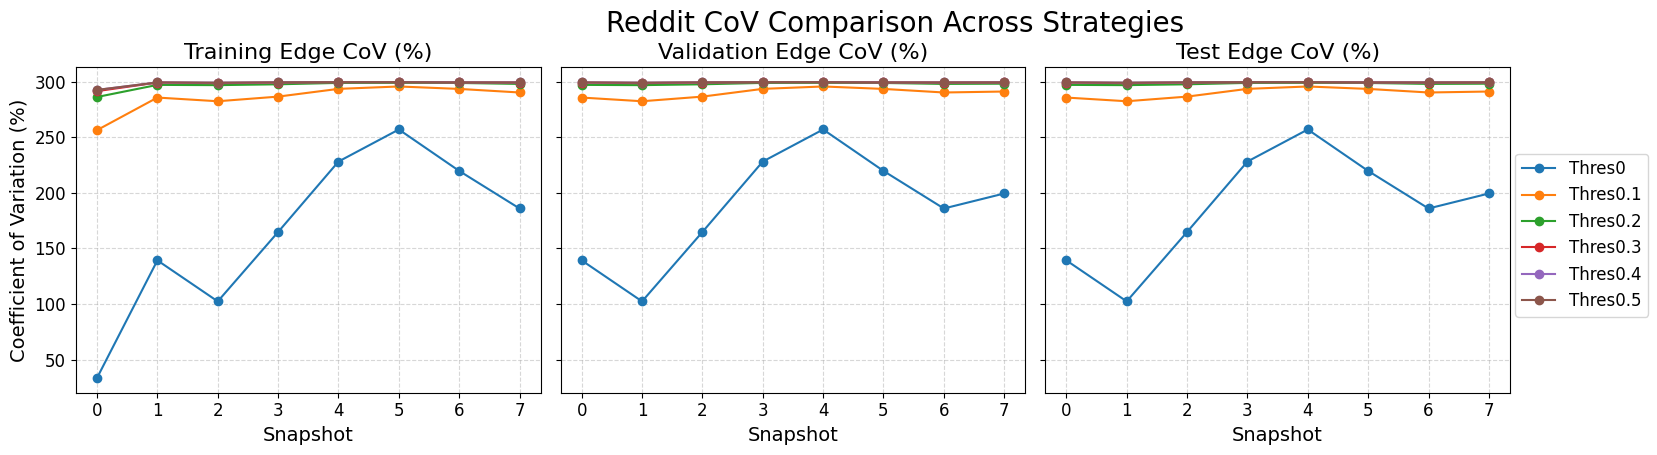

In [31]:

strategy_to_data = {}
for strategy_name, path_key in zip(["Thres0", "Thres0.1", "Thres0.2","Thres0.3","Thres0.4","Thres0.5"], ["Reddit_Thres0", "Reddit_Thres0.1", "Reddit_Thres0.2", "Reddit_Thres0.3", "Reddit_Thres0.4", "Reddit_MinCutFirst"]):
    data = parse_snapshots(experiment_to_results_path[path_key])
    strategy_to_data[strategy_name] = data

snapshot_ids, train_covs, val_covs, test_covs = compute_cov_per_snapshot(strategy_to_data)

plot_cov_comparison(snapshot_ids, train_covs, val_covs, test_covs, dataset="Reddit")